<img src="images/banner.png" alt="Folded outcrop" />

In [1]:
from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer, RotationAnglePlotter
from LoopStructural.datasets import load_laurent2016
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import logging
# logging.getLogger().setLevel(logging.INFO)

In /home/lgrose/miniconda3/envs/loop/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/lgrose/miniconda3/envs/loop/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/lgrose/miniconda3/envs/loop/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/lgrose/miniconda3/envs/loop/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/lgrose/

In [2]:
# load in the data from the provided examples
data, bb = load_laurent2016()
# define view for the figure
rotation= [-69.11981964111328, 15.704948425292969, 6.000146389007568]

# bb[1,2] = 10000

In [3]:
newdata = pd.DataFrame([[5923.504395,4748.135254,3588.621094,'s2',1.0]],columns=['X','Y','Z','feature_name','val'])
data = pd.concat([data,newdata],sort=False)
data[np.logical_and(data['feature_name'] == 's2',np.isnan(data['nx']))]
data.loc[np.logical_and(data['feature_name'] == 's0',~np.isnan(data['val'])),'feature_name'] = 's01'


### Modelling S2
In this model both F2 and F1 share the same cylindrical fold axis. As a result we only need to model the axial foliations. LoopStructural will give a warning saying that the 1st coordinate of the fold frame could not be built but this is not a problem for this model.

Not enough constraints for structural frame coordinate 1, 
Add some more and try again.
Not enough constraints for fold frame coordinate 1, 
Add some more and try again.



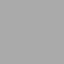

In [4]:
model = GeologicalModel(bb[0,:],bb[1,:])
model.set_model_data(data)
s2 = model.create_and_add_fold_frame('s2',
                                     nelements=10000, 
                                     buffer=0.5,
                                    solver='lu',
                                    damp=True)
viewer = LavaVuModelViewer(model)
viewer.add_scalar_field(s2[0],
                       cmap='prism')
viewer.add_isosurface(s2[0],
                     slices=[0,1])
viewer.add_data(s2[0])
viewer.rotation = rotation
viewer.interactive()
# viewer.display()


### Modelling S1
S1 is modelled using the geometry of S2 to constrain the axial foliation and a constant fold axis that is defined by the average intersection lineation between the gradient of S2 and the observations of S1. The geometry of the fold is constrained by fitting a periodic profile to the S-Plot which is a cross plot of the axial foliation scalar field value and the fold rotation angle. 

In [5]:
s1 = model.create_and_add_folded_fold_frame('s1',
                                            limb_wl=4, 
                                            av_fold_axis=True,
                                            nelements=50000,
                                            buffer=0.3,
                                            solver='lu'
                                           )



Not enough constraints for structural frame coordinate 1, 
Add some more and try again.
Not enough constraints for fold frame coordinate 1, 
Add some more and try again.


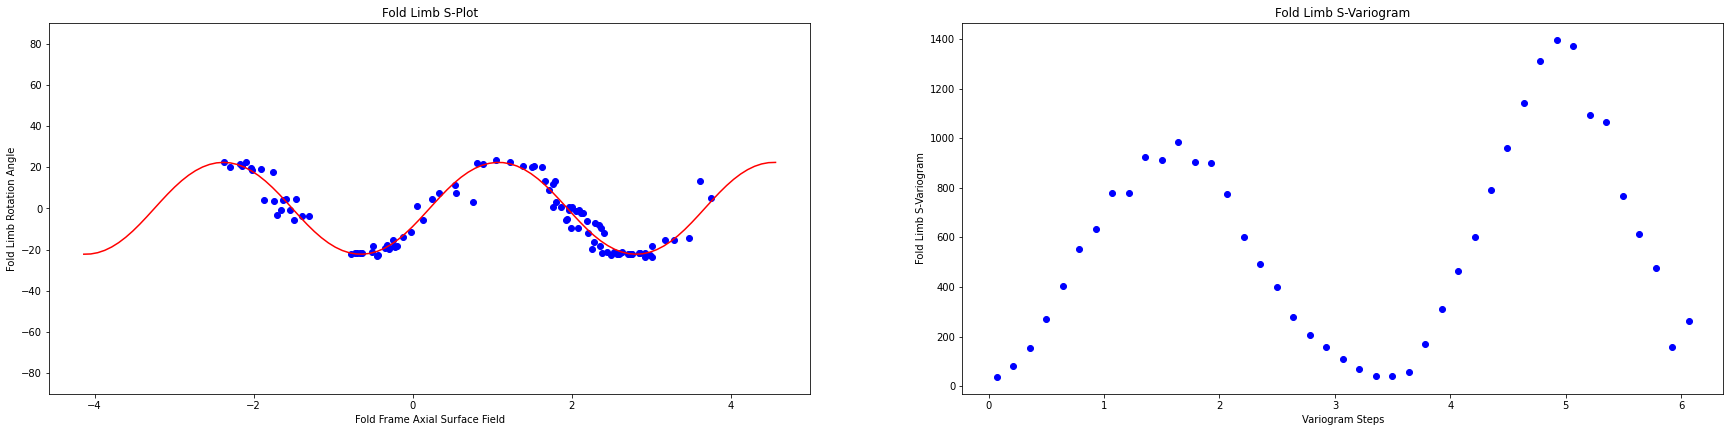

In [6]:
s1.fold.foldframe[0].set_model(model)
# s1.fold.foldframe[1].set_model(model)

s2_s1_splot = RotationAnglePlotter(s1)
s2_s1_splot.add_fold_limb_data()
s2_s1_splot.add_fold_limb_curve() 
s2_s1_splot.add_limb_svariogram()#fold_limb_
s2_s1_splot.default_titles()
s2_s1_splot.fig.delaxes(s2_s1_splot.ax[0][0])
s2_s1_splot.fig.delaxes(s2_s1_splot.ax[0][1])



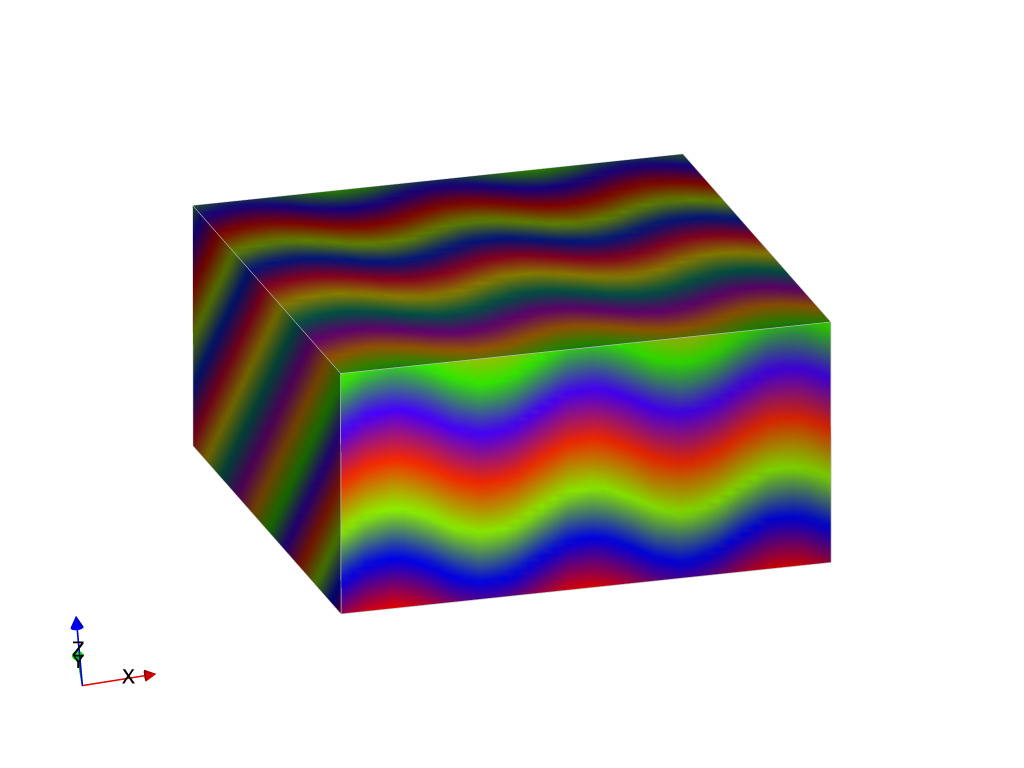

In [7]:
viewer = LavaVuModelViewer(model)
viewer.add_scalar_field(s1[0],
                       cmap='prism')
viewer.rotate([-69.11979675292969, 15.704944610595703, 6.00014591217041])
viewer.display()

# fig, ax = plt.subplots(1,2,figsize=(10,5))
# x = np.linspace(s2[0].min(),s2[0].max(),1000)
# ax[0].plot(x,s1.fold.fold_limb_rotation(x))
# ax[0].plot(s1.f['foliation'],s1['limb_rotation'],'bo')
# ax[1].plot(s1['limb_svariogram'].lags,s1['limb_svariogram'].variogram,'bo')


### Modelling S0
S0 is modelled using the same workflow as S1 except the S1 field is used as the axial foliation.

In [8]:
s0 = model.create_and_add_folded_foliation('s0',
                                            limb_wl=1., 
                                            av_fold_axis=True,
                                            nelements=50000,
                                            buffer=0.2,
                                            damp=True,
                                           solver='lu'
                                           )

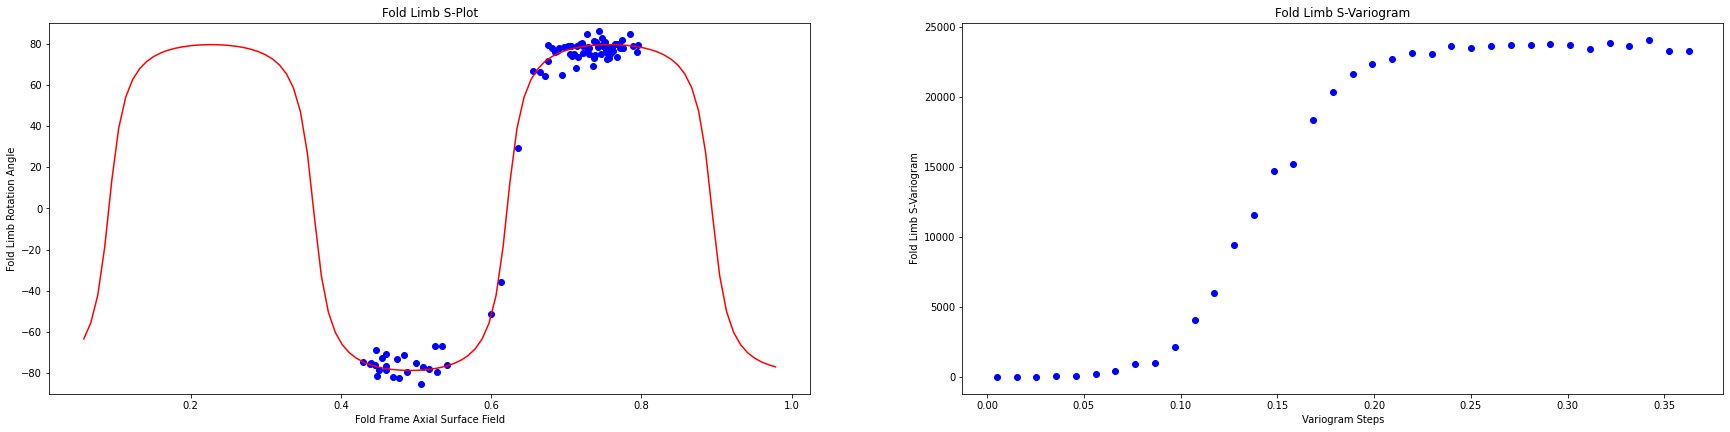

In [9]:
s0.fold.foldframe[0].set_model(model)
s1_s0_splot = RotationAnglePlotter(s0)
s1_s0_splot.add_fold_limb_data()
s1_s0_splot.add_fold_limb_curve()
s1_s0_splot.add_limb_svariogram()
s1_s0_splot.default_titles()
s1_s0_splot.fig.delaxes(s1_s0_splot.ax[0][0])
s1_s0_splot.fig.delaxes(s1_s0_splot.ax[0][1])


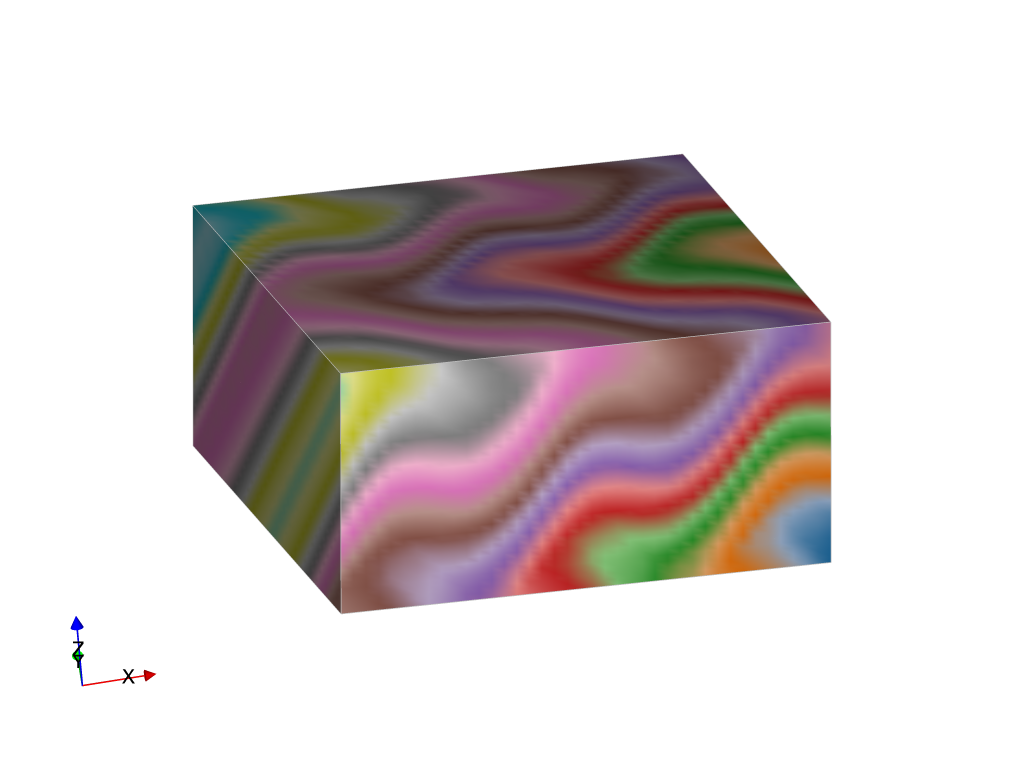

In [10]:
viewer = LavaVuModelViewer(model)
viewer.add_scalar_field(s0,
                       cmap='tab20')
viewer.rotation = rotation#[69.11979675292969, 15.704944610595703, 6.00014591217041]
viewer.display()
viewer.image('images/refolded_folds.jpg')


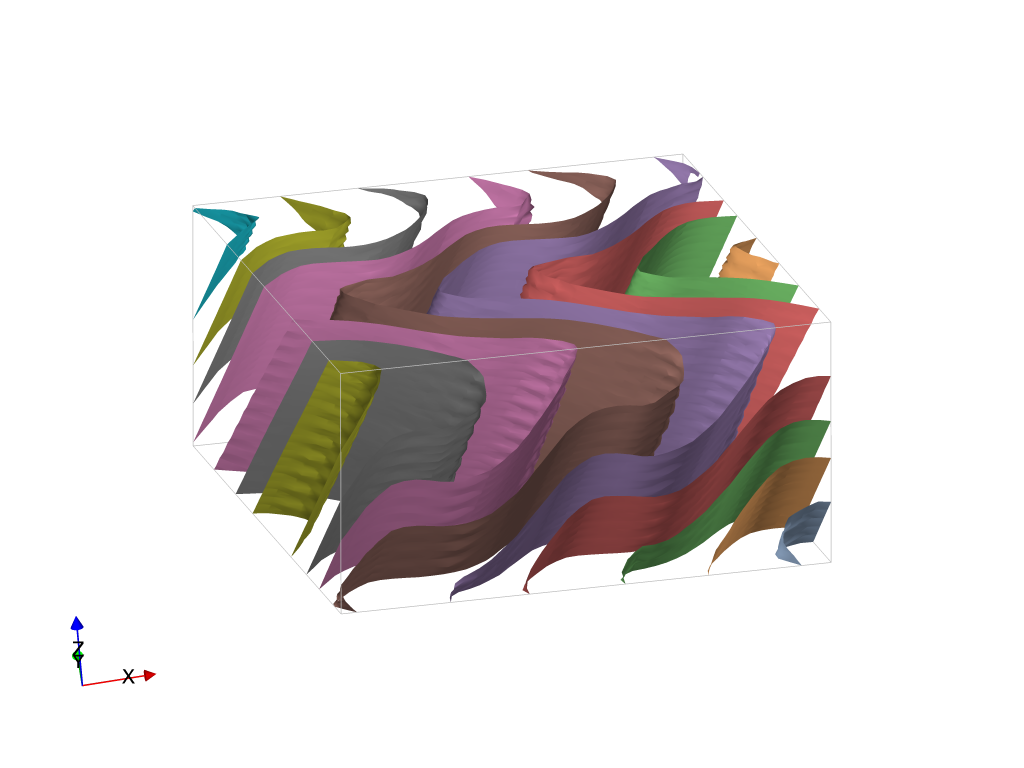

In [11]:
viewer = LavaVuModelViewer(model)
viewer.add_isosurface(s0,nslices=10,paint_with=s0,cmap='tab20')
# viewer.add_data(s0['feature'])
# viewer.add_fold(s0['fold'],locations=s0['support'].barycentre()[::80])
viewer.rotation = rotation
viewer.display()